# Meander Maker

If you haven't ever used the `googlemaps` python package, there are a few small setup steps to take first. You'll need to install it by running the next cell. Additionally, we will use `gmplot` to render the outputs and `polyline` to decode [Google's "Polyline"](https://developers.google.com/maps/documentation/utilities/polylineutility) hash. Finally, generate an API key to interface with Google's services. (There is a free tier, but if you use it a lot, they will start charging you for access.)

In [ ]:
!pip install googlemaps
!pip install gmplot
!pip install polyline
!pip install haversine

In [ ]:
!conda install -c conda-forge hdbscan

As mentioned above, if you would like to tinker around with the code, you'll need your own API key for Google Maps. You can register one from this address: [https://developers.google.com/places/web-service/get-api-key](https://developers.google.com/places/web-service/get-api-key). Once you have one, create a file in the directory containing this notebook called `.secret.key` and simply paste in your newly generated API key, no quotes or line breaks or anything. Save the file, exit, and you should be good to go.

In [1]:
import goplaces as gp

%load_ext autoreload
%autoreload 2

/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Let's decide which topic to explore:

In [2]:
loc = gp.get_loc(current=False)

Where would you like to start? 75th and greenwood, seattle


In [3]:
topic = gp.get_topic()

What theme would you like to explore today? ice cream


In [10]:
dest_list = gp.build_df(loc, topic)
dest_list

,lat,lng,name,label
0,47.682661,-122.355098,Bluebird Ice Cream,0
1,47.681488,-122.355097,Nutty Squirrel Gelato - Phinney Wood,0
2,47.685877,-122.337234,Ben & Jerry’s,0
3,47.679427,-122.374639,Frankie & Jo's Ballard,1
4,47.668500,-122.378612,Sweet Alchemy Ballard,1
5,47.669646,-122.383892,Parfait Ice Cream,1
6,47.667855,-122.383973,Full Tilt Ice Cream,1
7,47.668255,-122.385545,Salt & Straw,1
8,47.661505,-122.338178,Molly Moon's Homemade Ice Cream,2
9,47.661253,-122.334780,Fainting Goat Gelato - Wallingford,2


In [14]:
wlk = gp.meander(dest_list, mode='walking', verbose=True)
#gp.html_builder(loc, wlk, tab=True)

,lat,lng,name,label
0,47.682661,-122.355098,Bluebird Ice Cream,0
1,47.681488,-122.355097,Nutty Squirrel Gelato - Phinney Wood,0
2,47.685877,-122.337234,Ben & Jerry’s,0


waypoints: [{"lat":47.6814883,"lng":-122.3550969}]


ApiError: NOT_FOUND

---------TESTING-----------

In [ ]:
'1234567890'*8

In [7]:
import hdbscan
from haversine import haversine
import pandas as pd
import seaborn as sns
import googlemaps

In [ ]:
with open('.secret.key') as f:
    api_key = f.read().strip()

gmaps = googlemaps.Client(key=api_key)

In [ ]:
gmaps.

In [ ]:
df = dest_list.copy()
start = df[['lat', 'lng']].iloc[0]
stop = df[['lat', 'lng']].iloc[-1]
if len(df) > 2:
    wypts = df[['lat', 'lng']].iloc[1:-1].to_json(orient='records')
    print(wypts)
    

In [ ]:
gmaps.directions(start, stop, mode='walking', waypoints=wypts, optimize_waypoints=True)

In [ ]:
dest_list = gp.build_df(loc, topic)

In [ ]:
dest_list.loc[dest_list['label'] == 0]

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, 
                            min_samples=3, 
                            metric='haversine', 
                            allow_single_cluster=True)
clusterer.fit(df[['lat', 'lng']])
df['label'] = clusterer.labels_
print(df)

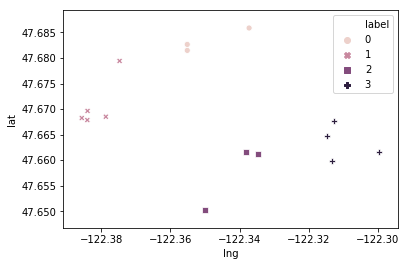

In [9]:
df = dest_list.copy()
sns.scatterplot(df['lng'], df['lat'], hue=df['label'], style=df['label']);

In [ ]:
loc, topic

In [ ]:
df = dest_list

In [ ]:
df = df.loc[df['label'] >= 0].sort_values('label').reset_index(drop=True)
df

In [ ]:
waypoints = df[['lat', 'lng']].iloc[1:-1].to_json(orient='records')
waypoints

In [ ]:
df.to_dict()